# Algorithms

These are the algorithms verbatim from the paper. They are faithful to the paper, rather than being best Python.


In [27]:
# Algorithm 1

def combine(U_n, n, U_m, m):
    U_nm = U_n * m + U_m
    nm = n*m
    return U_nm, nm

In [28]:
# Algorithm 2

def divide(U_nm, nm, n):
    U_m = U_nm // n
    U_n = U_nm % n
    m = nm // n
    return U_m, m, U_n

In [29]:
# Algorithm 3

def sample(U_n, n, m):
    if U_n < m:
        B = 1
        x = m
        U_x = U_n
    else:
        B = 0
        x = n-m
        U_x = U_n - m
    return U_x, x, B

In [30]:
# Algorithm 4

def expand(U_x, B, m):
    if B:
        U_n = U_x
    else:
        U_n = m + U_x
    return U_n

In [31]:
import random

def fetch():
    return random.randint(0,1)

In [32]:
# Algorithm 5

def generate_uniform(U_s, s, n, N):
    while True:
        while s < N:
            U_s, s = combine(U_s, s, fetch(), 2)
        U_s, s, b = sample(U_s, s,s%n)
        if not b:
            U_s, s, U_n = divide(U_s, s, n)
            return U_s, s, U_n

In [33]:
# Algorithm 6

def generate_bernoulli(U_s, s, m, n, N):
    U_s, s, U_n = generate_uniform(U_s, s, n, N)
    U_x, x, B = sample(U_n, n, m)
    U_s, s = combine(U_s, s, U_x, x)
    return U_s, s, B

In [34]:
# Algorithm 7

def make_distribution(weights):
    outputs = []
    offsets = []
    for i, w_i in enumerate(weights):
        offsets = offsets + [len(outputs)]
        outputs = outputs + [i]*w_i
    return outputs, offsets

TODO: This does not match the paper

TODO: document the output $i$

In [35]:
# Algorithm 8

def generate_distribution(U_s, s, N, weights, outputs, offsets):
    U_s, s, U_n = generate_uniform(U_s, s, len(outputs), N)
    i = outputs[U_n]
    U_s, s = combine(U_s, s, U_n - offsets[i], weights[i])
    return U_s, s, i

In [36]:
# Algorithm 9

def combine_bernoulli(U_s, s, N, m, n, B):
    if B:
        x = m
    else:
        x = n-m    
    U_s, s, U_x = generate_uniform(U_s, s, x, N)
    U_n = expand(U_x, B, m)
    U_s, s = combine(U_s, s, U_n, n)
    return U_s, s

In [37]:
# Algorithm 10

def combine_distribution(U_s, s, N, weights, outputs, offsets, i):
    U_s, s, U_x = generate_uniform (U_s, s, weights[i], N)
    U_s, s = combine(U_s, s, U_x + offsets[i], len(outputs))
    return U_s, s

# Graphs

Here are the functions used to calculate the graphs:


In [85]:
import math

class VonNeumannAlgorithm:
    def uniform_entropy(self, n):
        r = 1 # The smallest power of 2 >= than range 
        b = 0 # The number of bits in r
        while r < n:
            r *= 2
            b += 1
        return r*b/n

    def uniform_loss(self, n):
        return self.uniform_entropy(n) - math.log2(n)

class KnuthYaoAlgorithm:
    def uniform_entropy(self, n):
        def calculate_fdr_exact(u, depth):
            count = 0
            while u<n:
                u *= 2
                count += 1
            if n==u or depth==1:
                return count
            p = n/u
            return count + (1-p) * calculate_fdr_exact(u-n, depth-1)

        return calculate_fdr_exact(1, 8)

    def uniform_loss(self, n):
        return self.uniform_entropy(n) - math.log2(n)

def epsilon(n, N):
    if n==1:
        return 0
    p = (n-1)/N
    return -(p/(1-p))*math.log2(p) - math.log2(1-p)

def binary_entropy(p):
    if p==0:
        return 0
    return -p*math.log2(p) - (1-p)*math.log2(1-p)

class WorstCaseES:
    def __init__(self, bits):
        self.N = 1<<(bits-1)

    def uniform_loss(self, n):
        return epsilon(n, self.N)

    def uniform_entropy(self, n):
        return math.log2(n) + self.uniform_loss(n)

    def bernoulli_entropy(self, p):
        return binary_entropy(p) + self.uniform_loss(1/p)

class RealWorldES:
    def __init__(self, bits):
        self.N = 1<<(bits-1)
        self.s = 1

    def uniform_loss(self, n):
        while self.s<self.N:
            self.s = self.s * 2
        p = (self.s%n)/self.s
        self.s = self.s/n
        return binary_entropy(p)

    def uniform_entropy(self, n):
        return self.uniform_loss(n) + math.log2(n)

    def bernoulli_entropy(self, p):
        return binary_entropy(p) + self.uniform_loss(1/p)


def card_shuffling_loss(algorithm):
    def loss(size):
        total = 0
        for i in range(1,size+1):
            total += algorithm.uniform_loss(i)
        return total
    return loss

def card_shuffling_efficiency(algorithm):
    def efficiency(n):
        output = 0
        input = 0
        for i in range(1,n+1):
            output += math.log2(i)
            input += algorithm.uniform_entropy(i)
        return output / input
    return efficiency

class IntervalAlgorithm:
    def bernoulli_entropy(self, p):
        def simulate(depth, range, delta):
            if range>=p or depth>10 or range+delta<=p:
                return depth * delta
            delta *= 0.5
            depth += 1
            return simulate(depth, range, delta) + simulate(depth, range+delta, delta)
        return simulate(0, 0, 1)

class AliasAlgorithm:
    ky = KnuthYaoAlgorithm()
    
    def bernoulli_entropy(self, p):
        return self.ky.uniform_entropy(1/p)

def bernoulli_efficiency(algorithm):
    def efficiency(n):
        p = 1/n
        output = binary_entropy(p)
        return output/algorithm.bernoulli_entropy(p)
    return efficiency

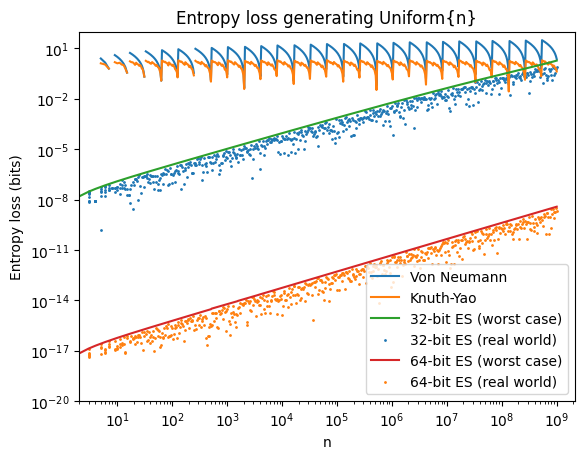

In [88]:
import numpy as np
import matplotlib.pyplot as plt

vn = VonNeumannAlgorithm()
ky = KnuthYaoAlgorithm()
es32_worst = WorstCaseES(32)
es32_real = RealWorldES(32)
es64_worst = WorstCaseES(64)
es64_real = RealWorldES(64)

def filter0(x):
    '''Don't show zeros on the graph'''
    return x if x>0 else math.nan

series = [math.floor(f) for f in np.logspace(0, 9, 640)]
epsilon32_losses = [es32_worst.uniform_loss(n) for n in series]
epsilon32_actuals = [es32_real.uniform_loss(n) for n in series]
epsilon64_losses = [es64_worst.uniform_loss(n) for n in series]
epsilon64_actuals = [es64_real.uniform_loss(n) for n in series]
vn_losses = [filter0(vn.uniform_loss(n)) for n in series]
ky_losses = [filter0(ky.uniform_loss(n)) for n in series]

plt.clf()

plt.title('Entropy loss generating Uniform{n}')

plt.xlabel('n')
plt.ylabel('Entropy loss (bits)')

plt.yscale('log')
plt.ylim(1e-20, 100)
plt.xlim(2, 2**31)
plt.xscale('log')

# plt.grid(True, which="both", ls="--")
plt.plot(series, vn_losses, label='Von Neumann')
plt.plot(series, ky_losses, label='Knuth-Yao')
plt.plot(series, epsilon32_losses, label='32-bit ES (worst case)')
plt.scatter(series, epsilon32_actuals, label='32-bit ES (real world)', s=1)
plt.plot(series, epsilon64_losses, label='64-bit ES (worst case)')
plt.scatter(series, epsilon64_actuals, label='64-bit ES (real world)', s=1)
plt.legend(loc='lower right')
plt.savefig('uniform_losses.png', dpi=600)
plt.show()

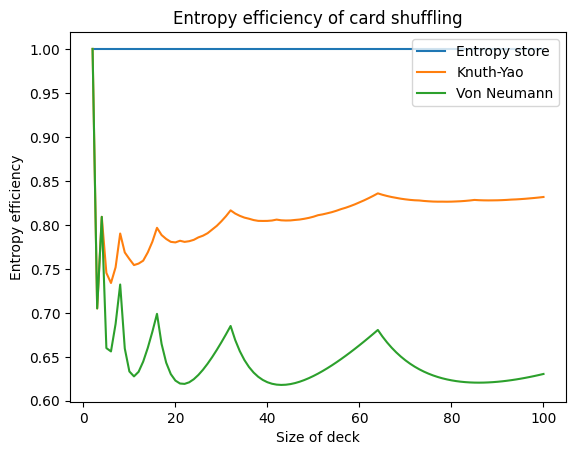

In [89]:
vn_efficiency_fn = card_shuffling_efficiency(vn)
ky_efficiency_fn = card_shuffling_efficiency(ky)
es32_efficiency_fn = card_shuffling_efficiency(es32_worst)

numbers = range(2,101)

vn_efficiency = [vn_efficiency_fn(n) for n in numbers]
ky_efficiency = [ky_efficiency_fn(n) for n in numbers]
es_efficiency = [es32_efficiency_fn(n) for n in numbers]

plt.clf()
plt.title('Entropy efficiency of card shuffling')

plt.xlabel('Size of deck')
plt.ylabel('Entropy efficiency')
plt.plot(numbers, es_efficiency, label='Entropy store')
plt.plot(numbers, ky_efficiency, label='Knuth-Yao')
plt.plot(numbers, vn_efficiency, label='Von Neumann')
plt.legend(loc='upper right')
plt.savefig('shuffling_efficiency.png', dpi=600)
plt.show()

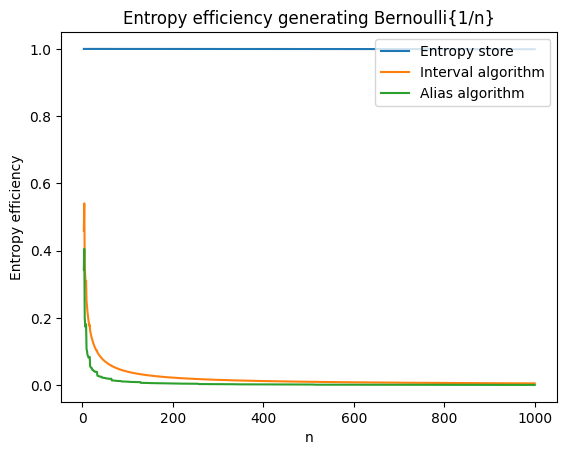

In [90]:
series = range(3,1001)
alias = AliasAlgorithm()
ia = IntervalAlgorithm()
alias_efficiency = [bernoulli_efficiency(alias)(n) for n in series]
interval_efficiency = [bernoulli_efficiency(ia)(n) for n in series]
es_efficiency_fn = bernoulli_efficiency(es_uniform_loss(32))
es_efficiency = [bernoulli_efficiency(es32_worst)(n) for n in series]

plt.clf()

plt.title('Entropy efficiency generating Bernoulli{1/n}')

plt.xlabel('n')
plt.ylabel('Entropy efficiency')

# plt.grid(True, which="both", ls="--")
plt.plot(series, es_efficiency, label='Entropy store')
plt.plot(series, interval_efficiency, label='Interval algorithm')
plt.plot(series, alias_efficiency, label='Alias algorithm')
plt.legend(loc='upper right')
plt.savefig('bernoulli_efficiency.png', dpi=600)
plt.show()

# Testing

In [40]:
U_s = 0
s = 1
N = 1<<31

U_s, s, U_n = generate_uniform(U_s, s, 6, N)

U_n

4

In [41]:
U_s, s, B = generate_bernoulli(U_s, s, 1, 3, N)
B

1

In [42]:
counts = [0,0]
for i in range(1,100):
    U_s, s, B = generate_bernoulli(U_s, s, 1, 6, N)
    counts[B] += 1

print(counts)

[79, 20]


In [43]:
make_distribution([1,2,3])

([0, 1, 1, 2, 2, 2], [0, 1, 3])

In [44]:
weights = [1,2,3]
outputs, offsets = make_distribution(weights)
U_s, s, x = generate_distribution(U_s, s, N, weights, outputs, offsets)

x

2

In [45]:
counts = [0,0,0]
for i in range(1,100):
    U_s, s, i = generate_distribution(U_s, s, N, weights, outputs, offsets)
    counts[i] += 1

print(counts)

[21, 31, 47]
